In [1]:
# load_data
import yfinance as yf
import pandas as pd

def load_data():

    btc = yf.download("BTC-USD", start="2025-05-06", end="2025-08-06", interval="1h", auto_adjust=True)
    eth = yf.download("ETH-USD", start="2025-05-06", end="2025-08-06", interval="1h", auto_adjust=True)

    btc = btc.reset_index()
    btc['Datetime'] = pd.to_datetime(btc['Datetime'])
    eth = eth.reset_index()
    eth['Datetime'] = pd.to_datetime(eth['Datetime'])

    btc_path = "/Users/muyuanchen/Desktop/Paper/BTC_1m_hourly.csv"
    eth_path = "/Users/muyuanchen/Desktop/Paper/ETH_1m_hourly.csv"
    btc.to_csv("BTC_1m_hourly.csv", index=False)
    eth.to_csv("ETH_1m_hourly.csv", index=False)


    return eth, btc


In [2]:
import numpy as np
import pandas as pd
import os
import yfinance as yf

def generate_synthetic_data():
    t = np.arange(0, 200, 0.1)
    regressor_1 = np.sin(t)
    regressor_2 = np.cos(5 * t)
    regressor_3 = np.sin(10 * t)
    regressor_4 = np.cos(20 * t)

    regressor_1[t >= 80] = 0
    regressor_2[t >= 80] = 0
    regressor_3[t >= 80] = 0
    regressor_4[t >= 80] = 0

    regressor_1[t >= 160] = np.sin(t[t >= 160])
    regressor_2[t >= 160] = np.cos(5 * t[t >= 160])
    regressor_3[t >= 160] = np.sin(10 * t[t >= 160])
    regressor_4[t >= 160] = np.cos(20 * t[t >= 160])
    # True coefficients
    theta_0 = 1.0
    theta_1 = 2.5
    theta_2 = 0.7
    theta_3 = 0.3
    
    A = np.hstack((regressor_1.reshape(-1, 1),
               regressor_2.reshape(-1, 1),
               regressor_3.reshape(-1, 1),
               regressor_4.reshape(-1, 1)))
    y_t = (theta_0 * regressor_1 +
        theta_1 * regressor_2 +
        theta_2 * regressor_3 +
        theta_3 * regressor_4).reshape(-1, 1) + np.random.normal(0, 0.1, size=(len(t), 1))
        
    return A, y_t

def extract_real_data_features(eth, btc):

    eth_nonlag = eth[2:]
    eth_lag1 = eth[1:-1]
    eth_lag2 = eth[0:-2]
    btc_lag1 = btc[1:-1]
    btc_lag2 = btc[0:-2]

    A = np.hstack([
        eth_lag1['Close'].values/1000,
        eth_lag2['Close'].values/1000,
        btc_lag1['Close'].values/100000,
        btc_lag2['Close'].values/100000,
    ])

    y_t = eth_nonlag['Close'].values/1000
    
    return A, y_t

def get_dataset(eth, btc, source):
   
    if source == "synthetic":
        
        return generate_synthetic_data()
    elif source == "real": 
        return extract_real_data_features(eth, btc)
    


In [3]:

# WEIGHT RLS


def weighted_rls_step(theta, P, row, y_t, beta):
    """
    Weighted RLS 单步更新
    theta: 当前参数向量 (p, 1)
    P: 当前逆协方差矩阵 (p, p)
    row: 当前样本 (p, 1)
    y_t: 当前目标值 (float)
    beta: 遗忘因子
    """
    
    newsample = row @ row.T
    theta = theta + (P @ row) * (y_t - row.T @ theta) / (beta + row.T @ P @ row)
    P = 1/beta * (P - (P @ newsample @ P) / (beta + row.T @ P @ row))
        
    return theta, P


In [4]:
def nlms_step(theta, row, y_t, eta):
    """
    NLMS 单步更新
    theta: 当前参数向量 (p, 1)
    row: 当前样本 (p, 1)
    y_t: 当前目标值 (float)
    eta: 学习率
    """
    theta = theta + ((eta * row) * (y_t - row.T @ theta)) / (1 + eta * row.T @ row)
    return theta

In [5]:
from sklearn.metrics import mean_squared_error, r2_score


def train_model(A_train, y_train, A_test, y_test,
                beta, eta,
                cond_thresh_switch,
                cond_thresh_reset,
                enable_switch):
    

    P = np.identity(A_train.shape[1])
    P_reset = np.identity(A_train.shape[1])
    theta = np.zeros((A_train.shape[1], 1))
 
    cond_list = []
    mode_list = []
    theta_list = []
    pred_y_list = []

    use_nlms = False

    for i, (row, y_t) in enumerate(zip(A_train, y_train.flatten())):
        row = row.reshape(-1, 1)
        theta, P = weighted_rls_step(theta, P, row, y_t, beta)
        cond_num = np.linalg.cond(P)

        if enable_switch:
            if cond_num > cond_thresh_reset:
                print(f"⚠ Step {i}: 条件数 {cond_num:.2f} > {cond_thresh_reset}，重置 P")
                P = P_reset
                cond_num = 1.0

            if not use_nlms and cond_num > cond_thresh_switch:
                print(f"⚠ Step {i}: 条件数 {cond_num:.2f} > {cond_thresh_switch}，切到 NLMS")
                use_nlms = True
            elif use_nlms and cond_num < cond_thresh_switch:
                print(f"ℹ Step {i}: 条件数 {cond_num:.2f} < {cond_thresh_switch}，切回 RLS")
                use_nlms = False

            if use_nlms:
                theta = nlms_step(theta, row, y_t, eta)
                mode_list.append("NLMS")
            else:
                theta = theta
                mode_list.append("RLS")
        else:
            theta = theta
            mode_list.append("RLS")

        cond_list.append(cond_num)
        theta_list.append(theta.flatten())
        pred_y_list.append((row.T @ theta).flatten())
  
    y_pred_test = A_test @ theta
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2 = r2_score(y_test, y_pred_test)

    return theta, pred_y_list, y_pred_test, mode_list, cond_list, theta_list, rmse, r2


In [6]:
def visualize_results(A_train, y_train, A_test, y_test,
                    pred_y_list, y_pred_test, mode_list, cond_list,
                    theta_list, cond_thresh_switch, cond_thresh_reset):
    import matplotlib.pyplot as plt

    # ==== 条件数曲线 ====
    plt.figure(figsize=(10, 5))
    plt.plot(cond_list, label="Condition Number")
    plt.axhline(cond_thresh_switch, color='orange', linestyle='--', label='Switch Threshold')
    plt.axhline(cond_thresh_reset, color='red', linestyle='--', label='Reset Threshold')
    plt.title("Condition Number of P Matrix")
    plt.xlabel("Iteration")
    plt.ylabel("Condition Number")
    plt.legend()
    plt.grid(True)
    plt.show()

    # ==== 预测对比图 ====
    plt.figure(figsize=(10, 5))
    plt.plot(y_test, label="Real")
    plt.plot(y_pred_test, label="Predicted")
    plt.title("RLS vs NLMS Prediction")
    plt.xlabel("Time (days)")
    plt.ylabel('ETH Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot theta evolution
    import matplotlib.pyplot as plt
    theta_array = np.array(theta_list)
    plt.figure(figsize=(10, 5))
    plt.plot(theta_array)
    plt.title("Theta Evolution")
    plt.xlabel("Iteration")
    plt.ylabel("Theta Values")
    plt.legend([f"Theta {i+1}" for i in range(theta_array.shape[1])])
    plt.grid(True)
    plt.show()  

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


⚠ Step 2: 条件数 54.00 > 50，切到 NLMS
⚠ Step 5: 条件数 208.25 > 200，重置 P
ℹ Step 5: 条件数 1.00 < 50，切回 RLS
⚠ Step 8: 条件数 53.83 > 50，切到 NLMS
⚠ Step 11: 条件数 204.27 > 200，重置 P
ℹ Step 11: 条件数 1.00 < 50，切回 RLS
⚠ Step 14: 条件数 52.20 > 50，切到 NLMS
⚠ Step 17: 条件数 202.28 > 200，重置 P
ℹ Step 17: 条件数 1.00 < 50，切回 RLS
⚠ Step 20: 条件数 52.89 > 50，切到 NLMS
⚠ Step 23: 条件数 210.20 > 200，重置 P
ℹ Step 23: 条件数 1.00 < 50，切回 RLS
⚠ Step 26: 条件数 55.66 > 50，切到 NLMS
⚠ Step 29: 条件数 214.76 > 200，重置 P
ℹ Step 29: 条件数 1.00 < 50，切回 RLS
⚠ Step 32: 条件数 56.22 > 50，切到 NLMS
⚠ Step 35: 条件数 216.61 > 200，重置 P
ℹ Step 35: 条件数 1.00 < 50，切回 RLS
⚠ Step 38: 条件数 55.50 > 50，切到 NLMS
⚠ Step 41: 条件数 211.53 > 200，重置 P
ℹ Step 41: 条件数 1.00 < 50，切回 RLS
⚠ Step 44: 条件数 54.28 > 50，切到 NLMS
⚠ Step 47: 条件数 212.14 > 200，重置 P
ℹ Step 47: 条件数 1.00 < 50，切回 RLS
⚠ Step 50: 条件数 56.98 > 50，切到 NLMS
⚠ Step 53: 条件数 227.75 > 200，重置 P
ℹ Step 53: 条件数 1.00 < 50，切回 RLS
⚠ Step 56: 条件数 61.30 > 50，切到 NLMS
⚠ Step 59: 条件数 240.83 > 200，重置 P
ℹ Step 59: 条件数 1.00 < 50，切回 RLS
⚠ Step 62: 条件数

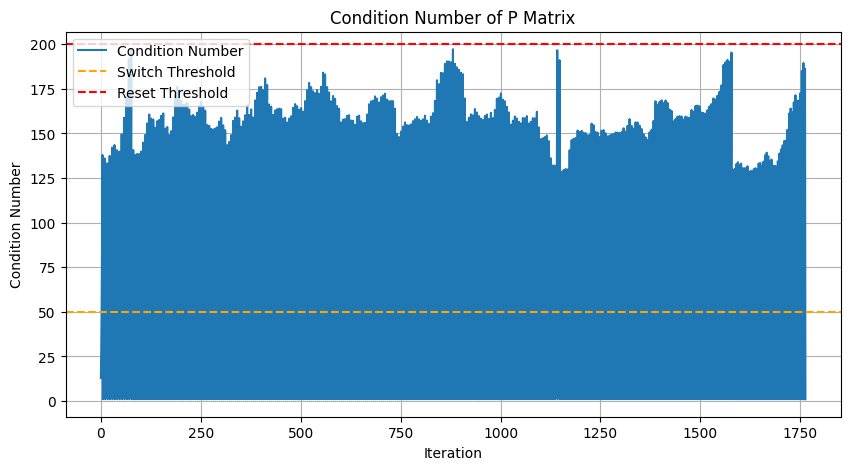

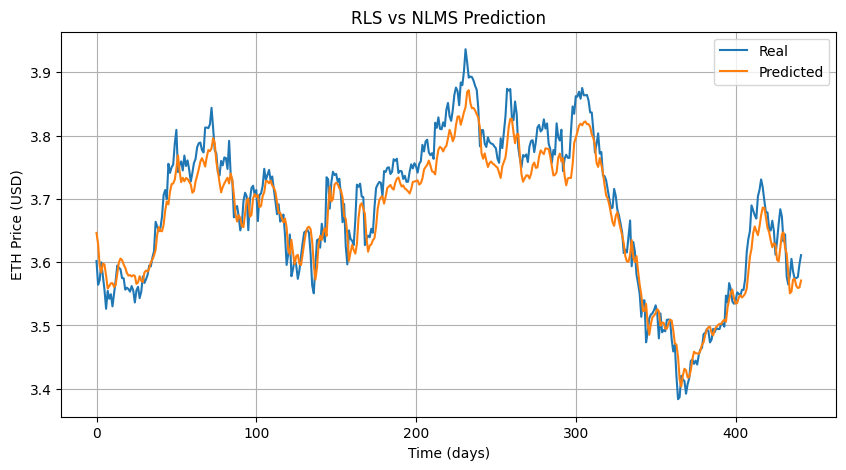

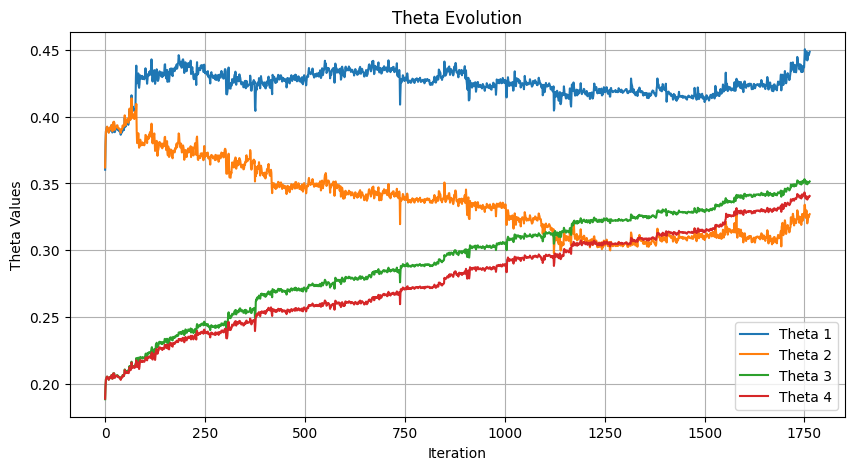

In [7]:

def main():
    # Step 1: Load real data
    eth, btc = load_data()

    # Step 2: Generate features and target
    source = "real"  # Change to "synthetic" for synthetic data
    
    A, y_t = get_dataset(eth, btc, source)

    # Step 3: Split
    if source == 'real':
        split_index = int(0.8 * len(A))
    elif source == 'synthetic':
        split_index = int(0.804 * len(A))

    A_train, A_test = A[:split_index], A[split_index:]
    y_train, y_test = y_t[:split_index], y_t[split_index:]

    # Step 4: Hyperparameters
    beta = 0.7
    eta = 0.1
    cond_thresh_switch = 50
    cond_thresh_reset = 200
    enable_switch = True
    
    # Step 5: Train model
    theta, pred_y_list, y_pred_test, mode_list, cond_list, theta_list, rmse, r2 = train_model(
        A_train, y_train, A_test, y_test,
        beta,
        eta,
        cond_thresh_switch,
        cond_thresh_reset, enable_switch)

    # Step 6: Evaluation
    print(f"\nTest RMSE: {rmse:.4f}, R²: {r2:.4f}")

    visualize_results(A_train, y_train, A_test, y_test,
                    pred_y_list, y_pred_test, mode_list, cond_list,
                    theta_list, cond_thresh_switch, cond_thresh_reset)

if __name__ == "__main__":
    main()